In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
import warnings
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
CURRENT_DIR = os.getcwd()
X_DIR = CURRENT_DIR + "\\data\\data_X.csv"
Y_DIR = CURRENT_DIR + "\\data\\data_Y.csv"

X = pd.read_csv(X_DIR)
y = pd.read_csv(Y_DIR).squeeze().ravel()

In [5]:
# Define preprocessing steps for numerical and categorical features
numeric_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['X7', 'X8', 'X9', 'X10', 'X11', 'X12']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [6]:
def evaluate_model(model, MODEL_NAME, model_scores, X, y):

    # Create the full pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', model)])

    # Set up 10-fold cross-validation
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    # Use cross_val_score for evaluation
    mae_scores = -cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error')
    mse_scores = -cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')

    # Calculate mean scores
    mae = np.mean(mae_scores)
    mse = np.mean(mse_scores)
    r2 = np.mean(r2_scores)

    # Store mean scores in model_scores dictionary
    model_scores['MAE'][MODEL_NAME] = {'scores': mae_scores, 'mean': mae}
    model_scores['MSE'][MODEL_NAME] = {'scores': mse_scores, 'mean': mse}
    model_scores['R2'][MODEL_NAME] = {'scores': r2_scores, 'mean': r2}

    print(f'{MODEL_NAME} is done training')

In [8]:
base_model_scores = {
    'MAE': {},
    'MSE': {},
    'R2': {}
}

model_list = [
    (RandomForestRegressor(random_state=42), "Random Forest"),
    (LinearRegression(), "Linear Regression"),
    (Ridge(random_state=42), "Ridge Regression"),
    (Lasso(random_state=42), "Lasso Regression"),
    (ElasticNet(random_state=42), "Elastic Net"),
    (XGBRegressor(random_state=42), "XGBoost")
]

full_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6','X7', 'X8', 'X9', 'X10', 'X11', 'X12']


for model, model_name in model_list:
    evaluate_model(model, model_name, base_model_scores, X, y)

Random Forest is done training
Linear Regression is done training
Ridge Regression is done training
Lasso Regression is done training
Elastic Net is done training
XGBoost is done training


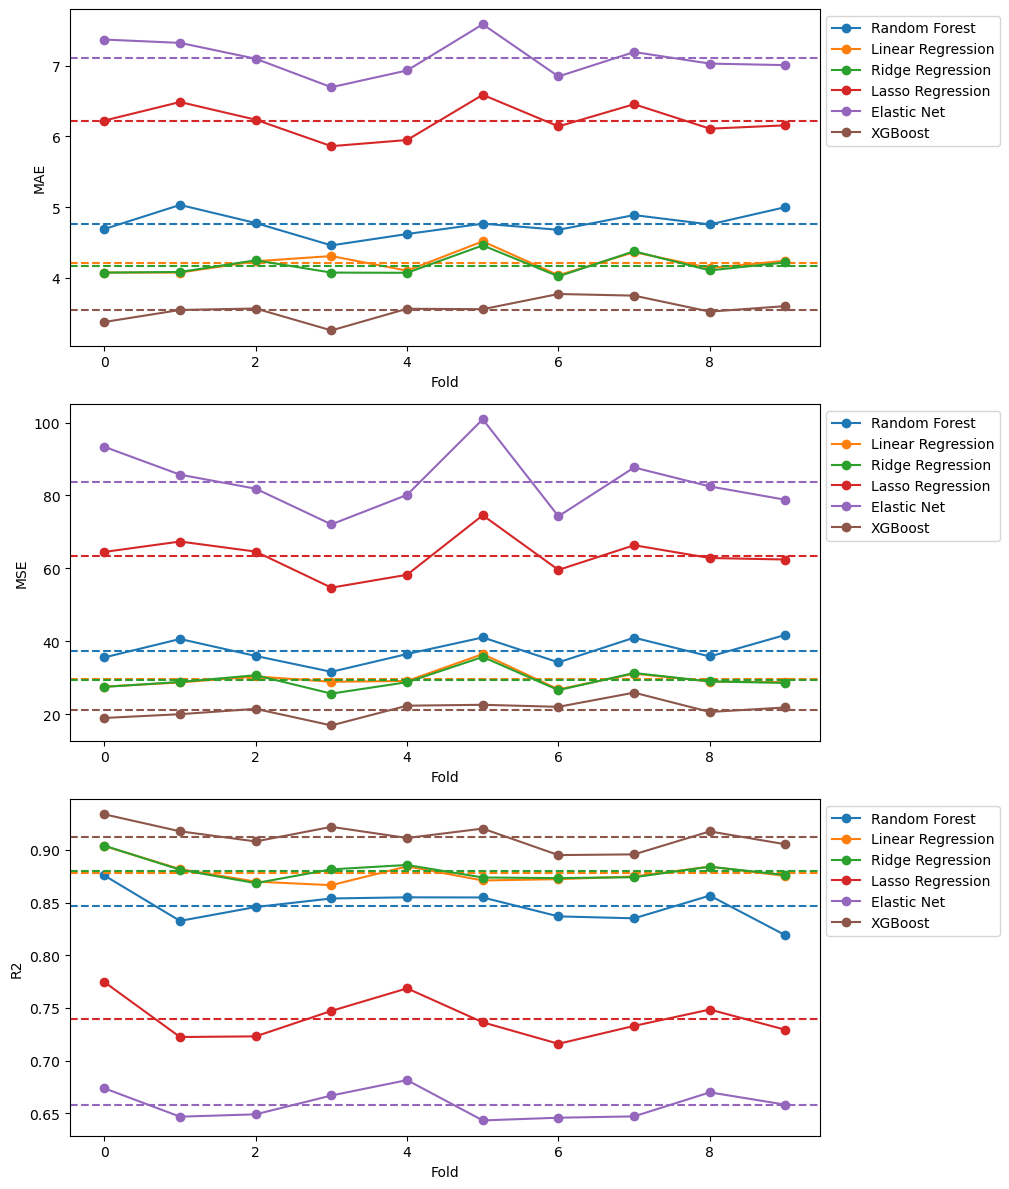

In [9]:
def print_model_scores(model_scores):
    # Plot all scores in one plot with 3 subplots
    plt.figure(figsize=(12, 12))

    # Counter for subplot index
    subplot_index = 1

    for metric in ['MAE', 'MSE', 'R2']:
        plt.subplot(3, 1, subplot_index)

        for model_name, scores_dict in model_scores[metric].items():
            scores = scores_dict['scores']
            mean_score = scores_dict['mean']
            color = plt.gca()._get_lines.get_next_color()  # Get the next available color

            plt.plot(scores, marker='o', label=f'{model_name}', color=color)
            plt.axhline(y=mean_score, linestyle='--', color=color)

        plt.xlabel('Fold')
        plt.ylabel(metric)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
        subplot_index += 1

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend
    plt.show()

print_model_scores(base_model_scores)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


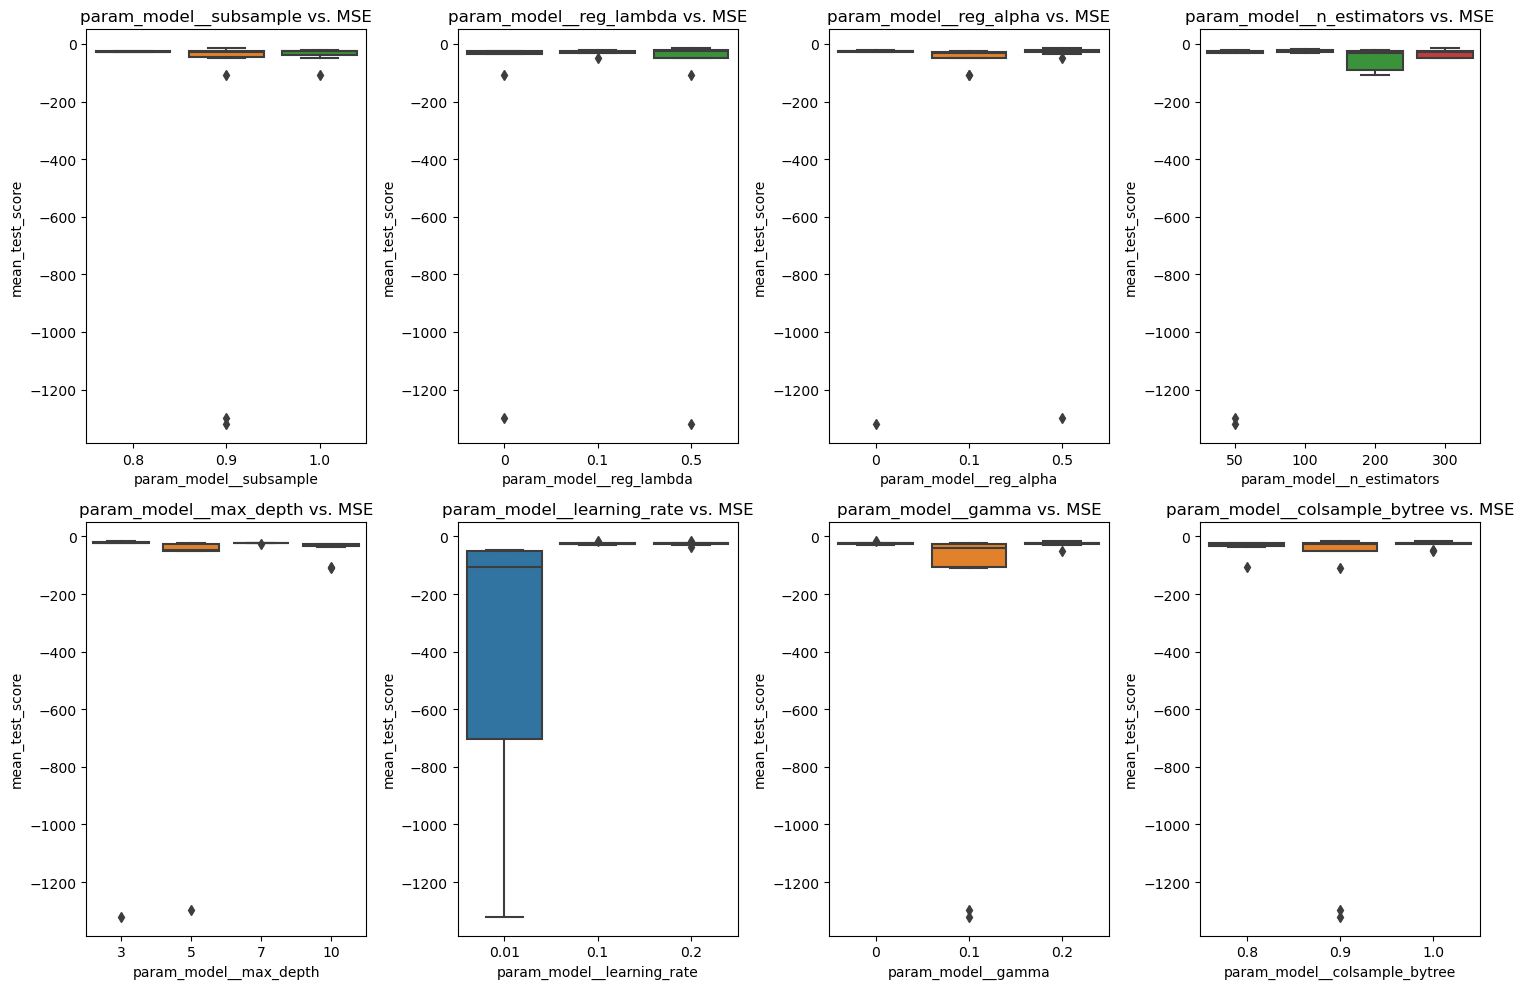

Best Parameters (Randomized): {'model__subsample': 0.9, 'model__reg_lambda': 0.5, 'model__reg_alpha': 0.5, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.9}
Mean Squared Error (Randomized Best Model): 12.740762017137481
R2 Score (Randomized Best Model): 0.9518013463727609


In [10]:
from sklearn.model_selection import RandomizedSearchCV

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

warnings.simplefilter("ignore", FutureWarning)

# Define the parameter distributions to search
param_dist = {
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [50, 100, 200, 300],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5],
}

# Define the XGBoost model
xgb_model = XGBRegressor(random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', xgb_model)])

# Set up 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Create RandomizedSearchCV object
randomized_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, n_iter=30, cv=cv, scoring='neg_mean_squared_error', verbose=1, random_state=42
)

# Fit the RandomizedSearchCV object to the data
randomized_search.fit(X_train, y_train)

# Extract the results from the RandomizedSearchCV
randomized_results = pd.DataFrame(randomized_search.cv_results_)

# Get relevant columns for plotting
param_cols = [col for col in randomized_results.columns if 'param_' in col]

# Plotting
plt.figure(figsize=(15, 10))

for i, param in enumerate(param_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=param, y='mean_test_score', data=randomized_results)
    plt.title(f'{param} vs. MSE')

plt.tight_layout()
plt.show()

# Get the best parameters and best model
randomized_best_params = randomized_search.best_params_
randomized_best_model = randomized_search.best_estimator_

# Print the best parameters
print("Best Parameters (Randomized):", randomized_best_params)

# Now you can use the best model for further evaluation or predictions
randomized_y_pred = randomized_best_model.predict(X_test)

# Evaluate the best model
randomized_best_mse = mean_squared_error(y_test, randomized_y_pred)
randomized_best_r2 = r2_score(y_test, randomized_y_pred)

print(f'Mean Squared Error (Randomized Best Model): {randomized_best_mse}')
print(f'R2 Score (Randomized Best Model): {randomized_best_r2}')


In [11]:
randomized_search.best_params_

{'model__subsample': 0.9,
 'model__reg_lambda': 0.5,
 'model__reg_alpha': 0.5,
 'model__n_estimators': 300,
 'model__max_depth': 3,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.9}

XGBoost Tuned is done training


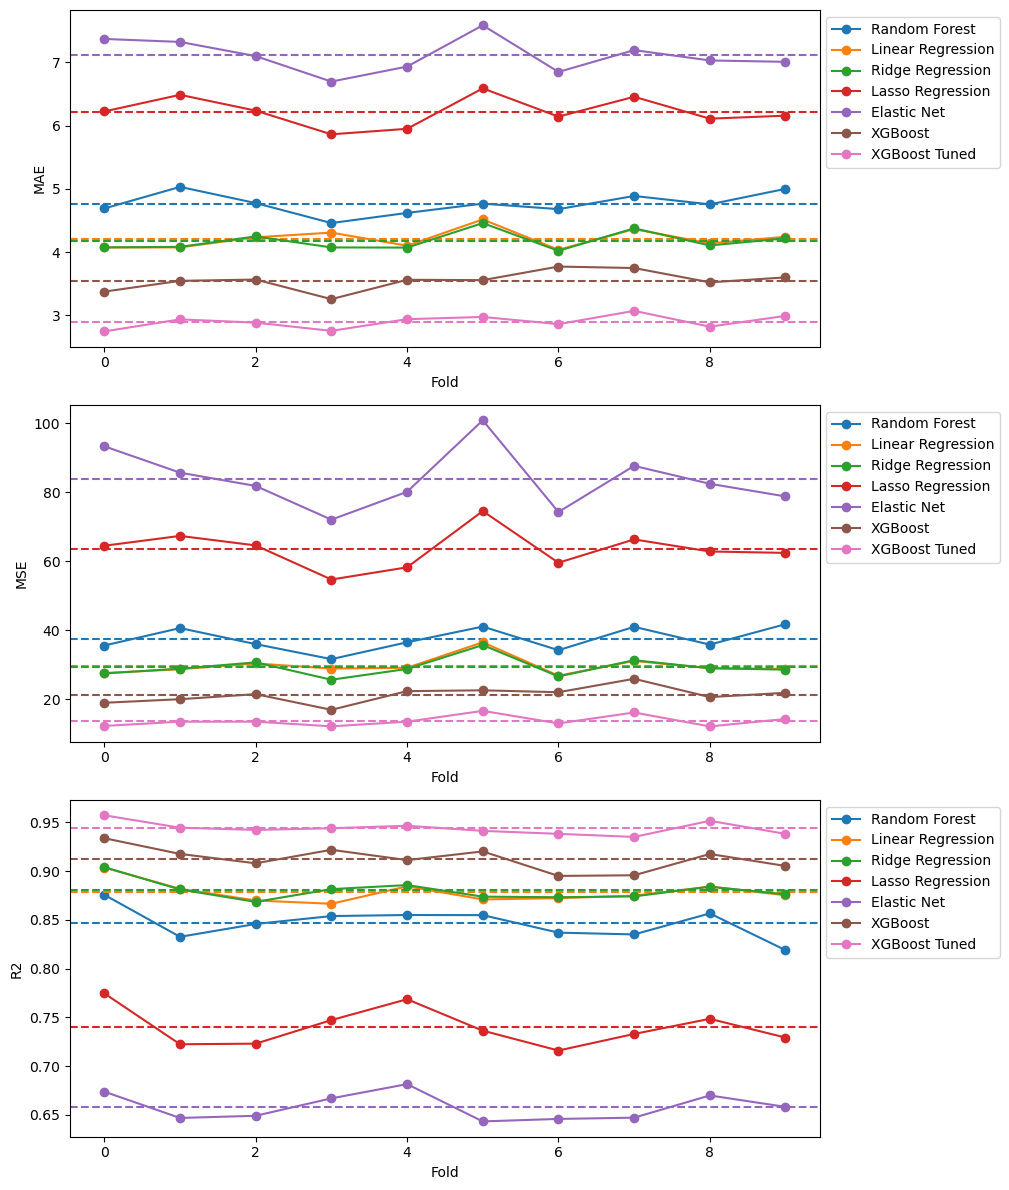

In [13]:
# Get the best hyperparameters
best_params = randomized_search.best_params_

# Define the XGBoost model with the best hyperparameters
best_xgb_model = XGBRegressor(
    random_state=42,
    max_depth=best_params['model__max_depth'],
    learning_rate=best_params['model__learning_rate'],
    n_estimators=best_params['model__n_estimators'],
    subsample=best_params['model__subsample'],
    colsample_bytree=best_params['model__colsample_bytree'],
    gamma=best_params['model__gamma'],
    reg_alpha=best_params['model__reg_alpha'],
    reg_lambda=best_params['model__reg_lambda']
)

evaluate_model(best_xgb_model, "XGBoost Tuned", base_model_scores, X, y)

print_model_scores(base_model_scores)


In [ ]:
# Access the mean scores for XGBoost Tuned from model_scores
xgboost_tuned_mean_scores = {
    'MAE': base_model_scores['MAE']['XGBoost Tuned']['mean'],
    'MSE': base_model_scores['MSE']['XGBoost Tuned']['mean'],
    'R2': base_model_scores['R2']['XGBoost Tuned']['mean']
}

# Print out the mean scores
print("Mean Scores for XGBoost Tuned:")
print("MAE:", xgboost_tuned_mean_scores['MAE'])
print("MSE:", xgboost_tuned_mean_scores['MSE'])
print("R2:", xgboost_tuned_mean_scores['R2'])


Mean Scores for XGBoost Tuned:
MAE: 2.9317401270837213
MSE: 14.207196181532453
R2: 0.9417175293530532


In [ ]:
# Define preprocessing steps for numerical and categorical features
numeric_features = ['X4', 'X5', 'X6']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine numerical and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [ ]:
model_list = [
    (RandomForestRegressor(random_state=42), "Random Forest FS (3)"),
    (LinearRegression(), "Linear Regression FS (3)"),
    (Ridge(random_state=42), "Ridge Regression FS (3)"),
    (Lasso(random_state=42), "Lasso Regression FS (3)"),
    (ElasticNet(random_state=42), "Elastic Net FS (3)"),
    (XGBRegressor(random_state=42), "XGBoost FS (3)")
]

three_features = ['X4', 'X5', 'X6']


for model, model_name in model_list:
    evaluate_model(model, model_name, base_model_scores, X[three_features], y)



Random Forest FS (3) is done training
Linear Regression FS (3) is done training
Ridge Regression FS (3) is done training
Lasso Regression FS (3) is done training
Elastic Net FS (3) is done training
XGBoost FS (3) is done training


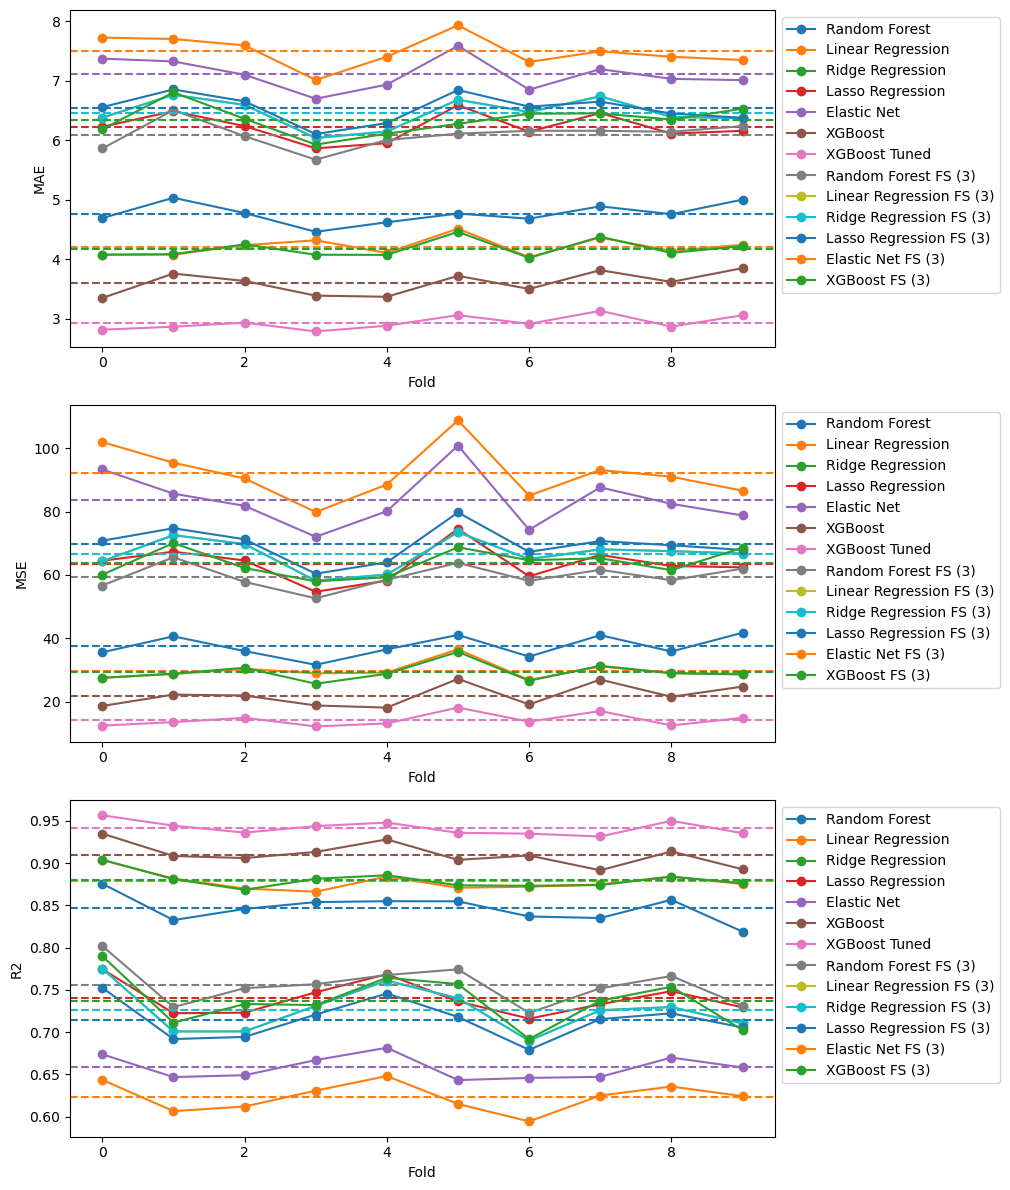

In [ ]:
print_model_scores(base_model_scores)